In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel("Online_Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Drop missing Customer IDs
df = df.dropna(subset=['CustomerID'])

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [5]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


In [6]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)


In [7]:
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Score'] = rfm[['R','F','M']].astype(int).sum(axis=1)


In [8]:
def segment(score):
    if score >= 12:
        return 'Loyal Customers'
    elif score >= 9:
        return 'Potential Loyalists'
    elif score >= 6:
        return 'Need Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment)


/tmp/ipython-input-134211769.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")


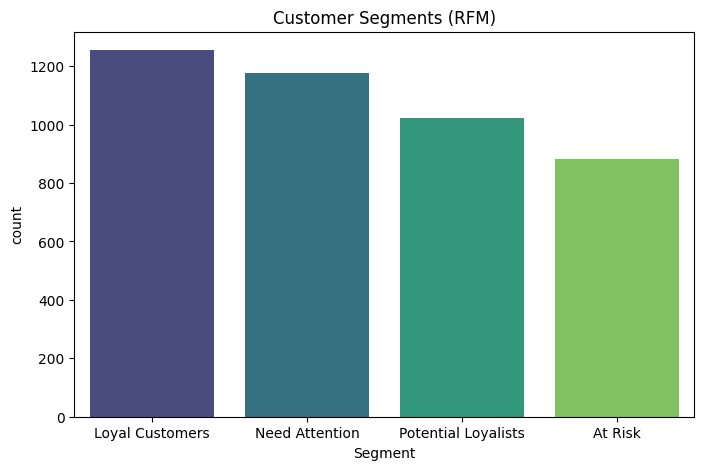

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments (RFM)")
plt.show()


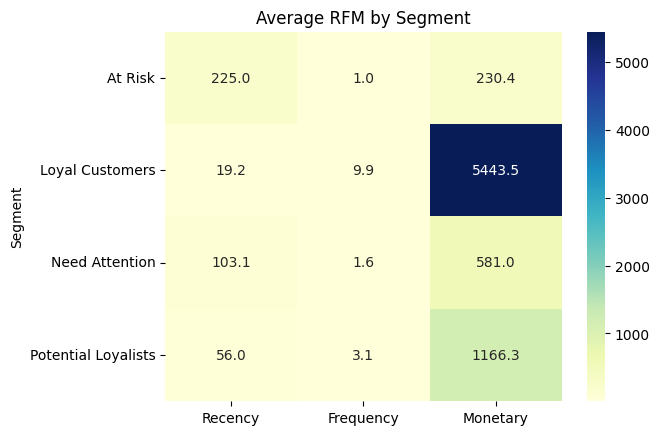

In [10]:
rfm_heatmap = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM by Segment")
plt.show()


In [11]:
rfm.to_csv("RFM_segments.csv", index=False)


/tmp/ipython-input-2264952400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")


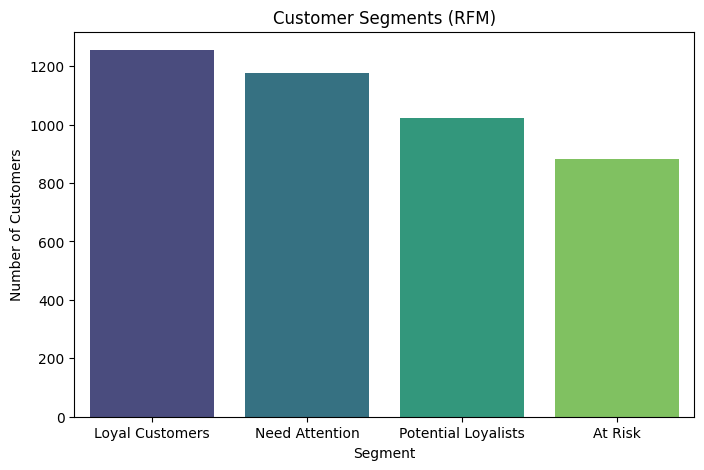

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments (RFM)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()


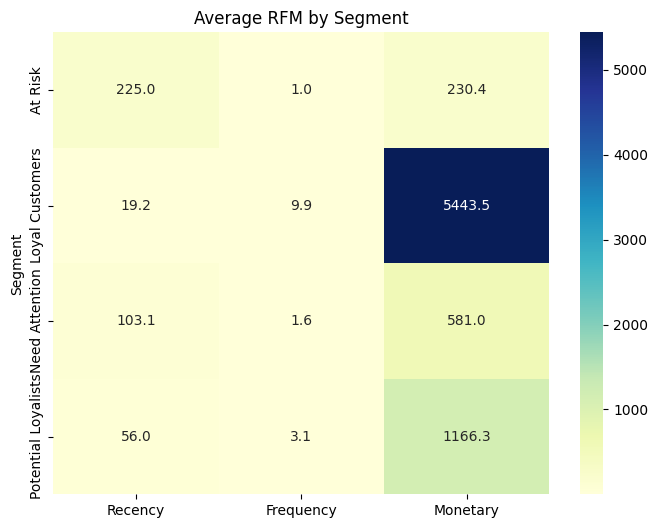

In [13]:
rfm_heatmap = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(1)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM by Segment")
plt.show()
